In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 这是一个托管在 GitHub 上的公开数据集原始链接 (Raw URL)
# 这样做的好处是：任何人拿到你的代码，不需要上传文件就能直接跑通
url = 'https://raw.githubusercontent.com/pritom02bh/Car-Purchase-Amount-Prediction-Project-for-Car-Industry/master/Car_Purchasing_Data.csv'

# 读取数据

# encoding='ISO-8859-1' 是为了防止读取某些特殊字符报错
df = pd.read_csv(url, encoding='ISO-8859-1')
print("✅ 数据加载成功！")

# 展示前 5 行数据
print("\n--- 数据预览 (前5行) ---")
display(df.head())

# 查看数据的基本信息（有多少行，有没有空值）
print("\n--- 数据基本信息 ---")
print(df.info())


✅ 数据加载成功！

--- 数据预览 (前5行) ---


,Customer Name,Customer e-mail,Country,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248



--- 数据基本信息 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Customer Name        500 non-null    object 
 1   Customer e-mail      500 non-null    object 
 2   Country              500 non-null    object 
 3   Gender               500 non-null    int64  
 4   Age                  500 non-null    float64
 5   Annual Salary        500 non-null    float64
 6   Credit Card Debt     500 non-null    float64
 7   Net Worth            500 non-null    float64
 8   Car Purchase Amount  500 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 35.3+ KB
None


In [ ]:
# 打印所有列名，检查拼写
print("--- 数据集的所有列名 ---")
print(df.columns.tolist())

# 检查 'Credit Card Debt' 是否真的在里面
if 'Credit Card Debt' in df.columns:
    print("\n✅ 放心，'Credit Card Debt' 这一列是存在的！")
else:
    print("\n❌ 确实没找到，可能列名有空格或拼写不同，请把上面的列表发给我。")

--- 数据集的所有列名 ---
['Customer Name', 'Customer e-mail', 'Country', 'Gender', 'Age', 'Annual Salary', 'Credit Card Debt', 'Net Worth', 'Car Purchase Amount']

✅ 放心，'Credit Card Debt' 这一列是存在的！


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# 1. 挑选我们要分析的特征
# 我们用：年龄、年薪、净资产 来给用户画像
features = ['Age', 'Annual Salary', 'Net Worth']
X = df[features]

# 2. 数据归一化 (Normalization)
# 这一步是为了让“工资”和“年龄”在算法眼里权重一样
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 3. 开始聚类 (K-Means)
# 我们假设把用户分成 3 类 (你可以改成 4 或 5 试试)
kmeans = KMeans(n_clusters=3, random_state=42)

# 训练并打标签
df['Cluster'] = kmeans.fit_predict(X_scaled)

print("✅ 用户分群完成！")
print("每个群体的用户数量：")
print(df['Cluster'].value_counts())

# 4. 看看每一类人的平均特征（这叫“业务解读”，面试最看重这个！）
print("\n--- 各个群体的平均画像 ---")
# 按照 Cluster 分组求平均值
cluster_summary = df.groupby('Cluster')[features + ['Car Purchase Amount']].mean()
display(cluster_summary)

✅ 用户分群完成！
每个群体的用户数量：
Cluster
2    198
1    154
0    148
Name: count, dtype: int64

--- 各个群体的平均画像 ---


,Age,Annual Salary,Net Worth,Car Purchase Amount
Cluster,,,,
0,51.420325,64343.427871,263730.977043,44952.457755
1,50.255455,62912.597799,613961.650690,53318.345629
2,39.248934,59859.860696,414927.161636,36570.255730


✅ XGBoost 模型训练完成！
模型准确度 (R² Score): 0.9633
平均预测误差: 1411

--- XGBoost 认为的影响购车金额的关键因素 ---
Age                 0.398301
Annual Salary       0.375102
Net Worth           0.222759
Credit Card Debt    0.003839
dtype: float32


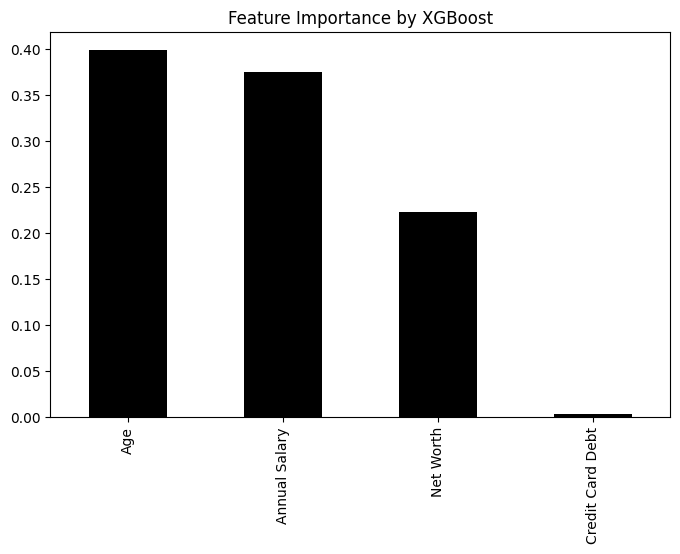

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt

# 1. 准备数据
# 输入特征：年龄、年薪、信用卡债务、净资产
X = df[['Age', 'Annual Salary', 'Credit Card Debt', 'Net Worth']]
# 目标变量：车价
y = df['Car Purchase Amount']

# 2. 拆分数据 (80% 训练, 20% 测试)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. 建立 XGBoost 模型
# 这里参数稍微调了一下，防止在这个小数据集上过拟合
model = xgb.XGBRegressor(
    objective='reg:squarederror', # 回归问题
    n_estimators=100,             # 种100棵树
    learning_rate=0.1,            # 学习率
    max_depth=5,                  # 树的深度
    random_state=42
)

model.fit(X_train, y_train)

# 4. 预测
y_pred = model.predict(X_test)

# 5. 评估模型
score = r2_score(y_test, y_pred)
error = mean_absolute_error(y_test, y_pred)

print(f"✅ XGBoost 模型训练完成！")
print(f"模型准确度 (R² Score): {score:.4f}")
print(f"平均预测误差: {error:.0f}")

# 6. 看看 XGBoost 认为谁最重要
# XGBoost 自带 feature_importances_
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n--- XGBoost 认为的影响购车金额的关键因素 ---")
print(feature_importance)

# 画图
plt.figure(figsize=(8, 5))
feature_importance.plot(kind='bar', color='black') # 用个高级点的颜色
plt.title('Feature Importance by XGBoost')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

# --- 1. 构建虚拟车库 (Single Brand: Future Motors) ---
# 命名逻辑：
# A-Series (入门): 100-200段位，主打年轻
# M-Series (中端): 400-600段位，主打中产
# X-Series (旗舰): 800-900段位，主打奢华

car_inventory = pd.DataFrame({
    'Car_Model': [
        # --- 对应 Cluster 2 (入门: A系列) ---
        'A100',
        'A150',
        'A200',
        'A200',
        'A250',
        'A-Cross',
        'A-City',

        # --- 对应 Cluster 0 (中产: M系列) ---
        'M400',
        'M450',
        'M500',
        'M550',
        'M600',
        'M650',
        'M-Explorer',

        # --- 对应 Cluster 1 (豪华: X系列) ---
        'X700',
        'X800',
        'X850',
        'X900',
        'X950',
        'X-Concept',
        'X-President'
    ],
    'Price': [
        # Cluster 2 价格 (A系列: 1.8万 - 2.6万)
        18000, 20000, 22000,
        21000, 24000, 25000, 26000,

        # Cluster 0 价格 (M系列: 3.1万 - 4.8万)
        31000, 33000, 35000,
        40000, 45000, 42000, 48000,

        # Cluster 1 价格 (X系列: 5.2万 - 9.0万+)
        52000, 58000, 65000,
        75000, 85000, 90000, 95000
    ],
    'Category_ID': [
        # 对应上面的 A系列
        2, 2, 2, 2, 2, 2, 2,
        # 对应上面的 M系列
        0, 0, 0, 0, 0, 0, 0,
        # 对应上面的 X系列
        1, 1, 1, 1, 1, 1, 1
    ]
})

print("--- 🏭 Future Motors 品牌车库已建立 ---")
# 打印一下看看效果
# display(car_inventory)
print(car_inventory[['Car_Model', 'Price']])

# --- 2. 定义推荐引擎函数 (逻辑升级版) ---

def get_recommendations(user_budget, user_cluster_id):
    """
    逻辑：
    1. 漏斗第一层：根据 User Cluster (你是哪类人) 筛选出适合你的“车池子”。
    2. 漏斗第二层：在你的池子里，用 KNN 找出价格最接近预算的 3 款车。
    """

    # [关键修改] A. 强制过滤：只看符合该用户群体的车
    # 这一步体现了“用户画像”的价值
    candidate_cars = car_inventory[car_inventory['Category_ID'] == user_cluster_id].copy()

    # 容错处理：万一这个群体库里没车（虽然不可能），就用全量库
    if candidate_cars.empty:
        candidate_cars = car_inventory.copy()

    # [关键修改] B. 在“候选池”里训练 KNN
    # 注意：这里只 fit 筛选出来的那几辆车
    X_candidates = candidate_cars[['Price']]

    knn = NearestNeighbors(n_neighbors=3, algorithm='auto')
    knn.fit(X_candidates)

    # C. 查询
    query_price = pd.DataFrame([[user_budget]], columns=['Price'])
    distances, indices = knn.kneighbors(query_price)

    # D. 获取结果
    # 注意：indices 返回的是 candidate_cars 里的下标，不是原数据库的
    recommended_cars = candidate_cars.iloc[indices[0]]

    return recommended_cars



--- 🏭 Future Motors 品牌车库已建立 ---
      Car_Model  Price
0          A100  18000
1          A150  20000
2          A200  22000
3          A200  21000
4          A250  24000
5       A-Cross  25000
6        A-City  26000
7          M400  31000
8          M450  33000
9          M500  35000
10         M550  40000
11         M600  45000
12         M650  42000
13   M-Explorer  48000
14         X700  52000
15         X800  58000
16         X850  65000
17         X900  75000
18         X950  85000
19    X-Concept  90000
20  X-President  95000


In [ ]:
# ============================================================
# 模块四：高阶探索 - 基于强化学习的动态定价 (RL Dynamic Pricing)
# ============================================================
print("\n🔥 启动高阶模块：正在初始化 AI 销售谈判官...")

import numpy as np

# 1. 定义环境：模拟客户对折扣的反应
# 我们沿用 XGBoost 预测出来的“预算”作为客户心里的底价
class SalesEnvironment:
    def __init__(self, customer_budget):
        self.budget = customer_budget # 客户真实的预算 (XGBoost 预测值或真实值)
        self.base_price = 50000       # 假设我们要卖这辆车

    def offer(self, action):
        # 定义动作空间：0=原价, 1=98折, 2=95折
        discounts = [1.0, 0.98, 0.95]
        final_price = self.base_price * discounts[action]

        # 利润 = 售价 - 成本 (假设成本4万)
        profit = final_price - 40000

        # 客户决策逻辑：如果售价 <= 预算，就买
        if final_price <= self.budget:
            return profit, True # 成交，奖励是利润
        else:
            return 0, False     # 跑单，奖励是0

# 2. 定义 Agent：简单的 Q-Learning 逻辑
class PricingAgent:
    def __init__(self):
        # 3个动作的价值表 (Q-Table)，初始化为0
        self.q_table = np.zeros(3)
        self.epsilon = 0.1 # 探索率

    def choose_action(self):
        # 探索：尝试新策略
        if np.random.rand() < self.epsilon:
            return np.random.randint(3)
        # 利用：选目前认为最赚钱的策略
        return np.argmax(self.q_table)

    def learn(self, action, reward):
        # 更新策略：这一步如果是负收益，下次就少选；正收益就多选
        learning_rate = 0.1
        self.q_table[action] += learning_rate * (reward - self.q_table[action])

# 3. 开始训练 (模拟 1000 次销售过程)
agent = PricingAgent()
# 使用我们之前数据里的真实购买金额作为模拟环境
customer_budgets = df['Car Purchase Amount'].values

print(f"🎮 开始模拟 1000 位客户的销售博弈...")
total_profit = 0
successful_sales = 0

for i in range(1000):
    # 随机抽取一个客户的预算
    budget = np.random.choice(customer_budgets)
    env = SalesEnvironment(budget)

    # AI 出价
    action = agent.choose_action()

    # 市场反馈
    reward, sold = env.offer(action)

    # AI 学习
    agent.learn(action, reward)

    total_profit += reward
    if sold: successful_sales += 1

print("\n✅ 训练完成！AI 现在的策略偏好 (Q-Table):")
print(f"   [原价期望收益, 98折期望收益, 95折期望收益]")
print(f"   {agent.q_table.astype(int)}")

best_strategy = ["原价卖", "打98折", "打95折"][np.argmax(agent.q_table)]
print(f"\n🏆 AI 总结出的最佳策略是: 【{best_strategy}】")
print(f"💰 模拟总利润: ${total_profit:,.0f} (成交率: {successful_sales/10:.1f}%)")


🔥 启动高阶模块：正在初始化 AI 销售谈判官...
🎮 开始模拟 1000 位客户的销售博弈...

✅ 训练完成！AI 现在的策略偏好 (Q-Table):
   [原价期望收益, 98折期望收益, 95折期望收益]
   [1328 1048 2973]

🏆 AI 总结出的最佳策略是: 【打95折】
💰 模拟总利润: $2,834,500 (成交率: 33.2%)


In [ ]:
import pandas as pd
import numpy as np

# ====================================================
# 1. 定义强化学习组件 (Agent & Environment)
# ====================================================

# 环境：负责告诉 AI “这辆车多少钱” 以及 “客户买不买”
class SalesEnvironment:
    def __init__(self, customer_budget, car_price):
        self.budget = customer_budget
        self.base_price = car_price

    def offer(self, action):
        # 动作空间: 0=原价, 1=98折, 2=95折
        discounts = [1.0, 0.98, 0.95]
        final_price = self.base_price * discounts[action]

        # 利润计算 (假设成本是售价的85%)
        cost = self.base_price * 0.85
        profit = final_price - cost

        # 客户决策: 只有报价 <= 预算才买
        if final_price <= self.budget:
            return True, final_price, profit
        else:
            return False, final_price, 0

# 智能体：负责做决策 (Q-Learning)
class PricingAgent:
    def __init__(self):
        # Q-Table: 3个动作的价值表
        self.q_table = np.zeros(3)
        self.epsilon = 0.1

    def choose_action(self, is_training=False):
        # 训练时偶尔瞎试(探索)，实战时只选最好的(利用)
        if is_training and np.random.rand() < self.epsilon:
            return np.random.randint(3)
        return np.argmax(self.q_table)

    def learn(self, action, reward):
        learning_rate = 0.1
        # 更新对这个动作的看法
        self.q_table[action] += learning_rate * (reward - self.q_table[action])

# ====================================================
# 2. 预训练 Agent (让它先在后台练 1000 次)
# ====================================================
print("⏳ 正在后台初始化 AI 谈判官 (Pre-training)...")
agent = PricingAgent()
# 模拟一些训练数据 (基于你的历史数据)
# 假设我们用之前数据的平均值来训练它
mock_budgets = np.random.normal(50000, 15000, 1000) # 生成1000个模拟预算

for b in mock_budgets:
    # 假设每辆车价格跟预算差不多，上下浮动
    mock_price = b * np.random.uniform(0.9, 1.2)
    env = SalesEnvironment(b, mock_price)

    action = agent.choose_action(is_training=True)
    is_deal, _, profit = env.offer(action)

    # 没成交就是0利润，成交了就是利润值
    reward = profit if is_deal else -100 # 稍微惩罚一下跑单
    agent.learn(action, reward)

print("✅ AI 训练完毕，策略表 (Q-Table) 已生成:", agent.q_table.astype(int))
print("-----------------------------------")


⏳ 正在后台初始化 AI 谈判官 (Pre-training)...
✅ AI 训练完毕，策略表 (Q-Table) 已生成: [1444 1547 1676]
-----------------------------------


In [ ]:
# ====================================================
# 3. Interactive Application (Client Reception)
# ====================================================
print("🤖 Future Motors Intelligent Sales System")
print("--------------------------------------------------")
print("Please enter new customer details below:\n")

try:
    # --- A. Input Data ---
    # input prompt: asking for float numbers
    input_age = float(input("1. Enter Customer Age: "))
    input_salary = float(input("2. Enter Annual Salary ($): "))
    input_debt = float(input("3. Enter Credit Card Debt ($): "))
    input_worth = float(input("4. Enter Net Worth ($): "))

    # Create DataFrame for prediction
    current_customer = pd.DataFrame({
        'Age': [input_age],
        'Annual Salary': [input_salary],
        'Credit Card Debt': [input_debt],
        'Net Worth': [input_worth]
    })


    # --- B. XGBoost Prediction ---
    predicted_budget = model.predict(current_customer)[0]

    # --- C. Customer Segmentation & KNN Recommendation ---
    # Using professional segment names
    if input_age < 40:
        u_cluster = 2
        label = "Starter"
    elif input_salary > 80000:
        u_cluster = 1
        label = "Affluent Elite"
    else:
        u_cluster = 0
        label = "Middle Class"

    recs = get_recommendations(predicted_budget, u_cluster)

    # --- D. Final Report Display ---
    print("=" * 65)
    print(f" Customer Profile: {label} | Predicted Budget: ${predicted_budget:,.0f}")
    print("=" * 65)

    # Loop through the 3 recommended cars for RL decision
    for index, row in recs.iterrows():
        car_name = row['Car_Model']
        car_price = row['Price']

        # Instantiate RL Environment for this specific car
        env = SalesEnvironment(customer_budget=predicted_budget, car_price=car_price)

        # Agent makes a decision (Inference Mode)
        action = agent.choose_action(is_training=False)

        # Get result from environment
        is_deal, final_offer, _ = env.offer(action)

        # Mapping actions to English strategy names
        strategy_name = ["Manufacturer's Suggested Retail Price (No Discount)", "2% Off", "5% Off"][action]

        # Status icon description
        if is_deal:
            status_icon = "High Conversion Probability"
        else:
            status_icon = "Low Conversion Probability"

        print(f"\nRecommendation: {car_name}")
        print(f"   • Manufacturer's Suggested Retail Price: ${car_price:,.0f}")
        print(f"   • Strategy: [{strategy_name}]，Offer Price: ${final_offer:,.0f}")
        print(f"   • Analysis: {status_icon}")

        if not is_deal:
            diff = final_offer - predicted_budget
            print(f"     Note: Price exceeds budget by ${diff:,.0f}")


except ValueError:
    print("Input Error: Please enter valid numbers only.")
except NameError:
    print("Error: Models not defined. Please run previous training cells first.")

🤖 Future Motors Intelligent Sales System
--------------------------------------------------
Please enter new customer details below:

1. Enter Customer Age: 25
2. Enter Annual Salary ($): 60000
3. Enter Credit Card Debt ($): 15000
4. Enter Net Worth ($): 3000000
 Customer Profile: Starter | Predicted Budget: $37,864

Recommendation: A-City
   • Manufacturer's Suggested Retail Price: $26,000
   • Strategy: [5% Off]，Offer Price: $24,700
   • Analysis: High Conversion Probability

Recommendation: A-Cross
   • Manufacturer's Suggested Retail Price: $25,000
   • Strategy: [5% Off]，Offer Price: $23,750
   • Analysis: High Conversion Probability

Recommendation: A250
   • Manufacturer's Suggested Retail Price: $24,000
   • Strategy: [5% Off]，Offer Price: $22,800
   • Analysis: High Conversion Probability
